<a href="https://colab.research.google.com/github/AbigailDerton/titanic-ml/blob/main/Titanic_Survival_Kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Titanic - Machine Learning from Disaster

Author: Abigail Derton ([LinkedIn](https://www.linkedin.com/in/abigail-derton/), [GitHub](https://github.com/AbigailDerton))

This notebook is my submission to the classic [Titanic: Machine Learning from Disaster](https://www.kaggle.com/competitions/titanic) competition on Kaggle. Using models from the scikit-learn library, I compare several machine learning approaches to predict which passengers survived the Titanic shipwreck.

The workflow is organized as follows:

1. Import required libraries and load the data

2. Explore and visualize key features

3. Build a data preprocessing pipeline

4. Train and tune machine learning models to predict passenger survival

5. Evaluate model performance on unseen test data

##1. Import required libraries and load the data

Load required libraries:

In [22]:
import os # used to check/change working directory
import pandas as pd # for reading/manipulating pandas dataframes
import numpy as np # for getting unique values in a column
import matplotlib.pyplot as plt # for data visualization
import seaborn as sns # for data visualization
from pandas.plotting import scatter_matrix # for plotting every numerical attribute against every other numerical attribute

# Install libraries for data preprocessing class
from sklearn.impute import SimpleImputer # for median imputation (missing passenger ages)
from sklearn.preprocessing import OneHotEncoder # for encoding categorical variables
from sklearn.base import BaseEstimator, TransformerMixin # for custom data cleaning pipeline class
from sklearn.pipeline import Pipeline # Used to create a pipeline including custom data preprocessing class. this will be useful for hyperparameter tuning.
from sklearn.preprocessing import StandardScaler # for standardizing numeric features

# Install libraries for ML models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score # K-fold cross validation
from sklearn.model_selection import GridSearchCV # for hyperparameter tuning

# Show plots inline:
%matplotlib inline

Load the data:

In [4]:
train_set = pd.read_csv("titanic_data/train.csv")
test_set = pd.read_csv("titanic_data/test.csv")

## 2. Explore and visualize key features

Look at first few rows of each dataframe and examine summary statistics:

In [5]:
print(train_set.head()) # look at the first few rows of data
print(train_set.info()) # look at data types and non-null counts
print(train_set.describe()) # statistical summaries of numerical columns
print(train_set.shape) # number of rows and columns

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  
<c

In [6]:
print(test_set.head()) # look at the first few rows of data
print(test_set.info()) # look at data types and non-null counts
print(test_set.shape) # number of rows and columns

   PassengerId  Pclass                                          Name     Sex  \
0          892       3                              Kelly, Mr. James    male   
1          893       3              Wilkes, Mrs. James (Ellen Needs)  female   
2          894       2                     Myles, Mr. Thomas Francis    male   
3          895       3                              Wirz, Mr. Albert    male   
4          896       3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female   

    Age  SibSp  Parch   Ticket     Fare Cabin Embarked  
0  34.5      0      0   330911   7.8292   NaN        Q  
1  47.0      1      0   363272   7.0000   NaN        S  
2  62.0      0      0   240276   9.6875   NaN        Q  
3  27.0      0      0   315154   8.6625   NaN        S  
4  22.0      1      1  3101298  12.2875   NaN        S  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       ------------

The training set includes 12 features and 891 rows. The features Age, Cabin, and Embarked contain some null values. Approximately 38.4% of passengers survived, indicating a reasonably balanced target variable. The features Name, Sex, Ticket, Cabin, and Embarked are text/categorical and will need to be converted to numeric format before fitting machine learning models.

Examine the distribution of numeric features:

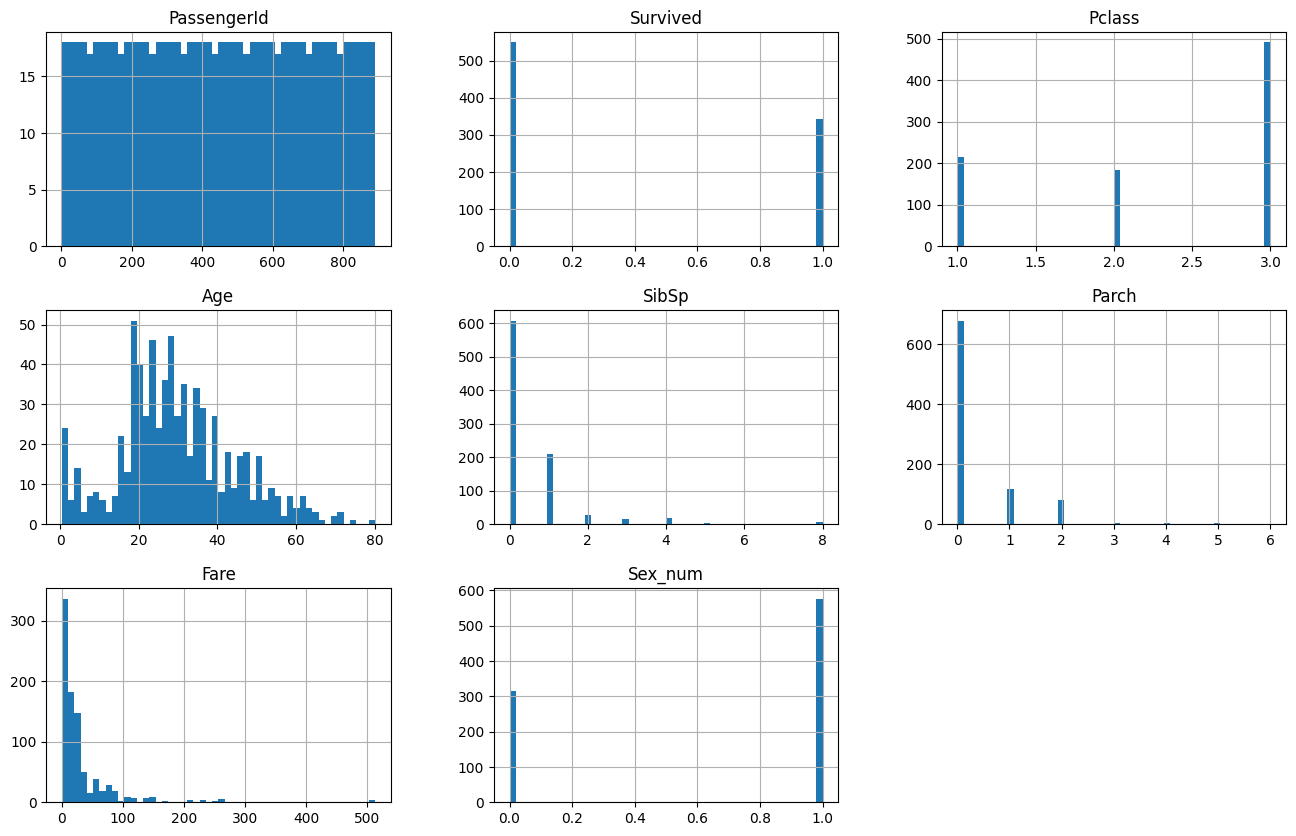

In [7]:
# create a numeric column for passenger sex
train_set["Sex_num"] = train_set["Sex"].map({"female":0, "male": 1})

# plot histograms of all numeric features
train_set.hist(bins=50, figsize=(16,10))
plt.show()

Examine the correlations between numeric features and passenger survival.

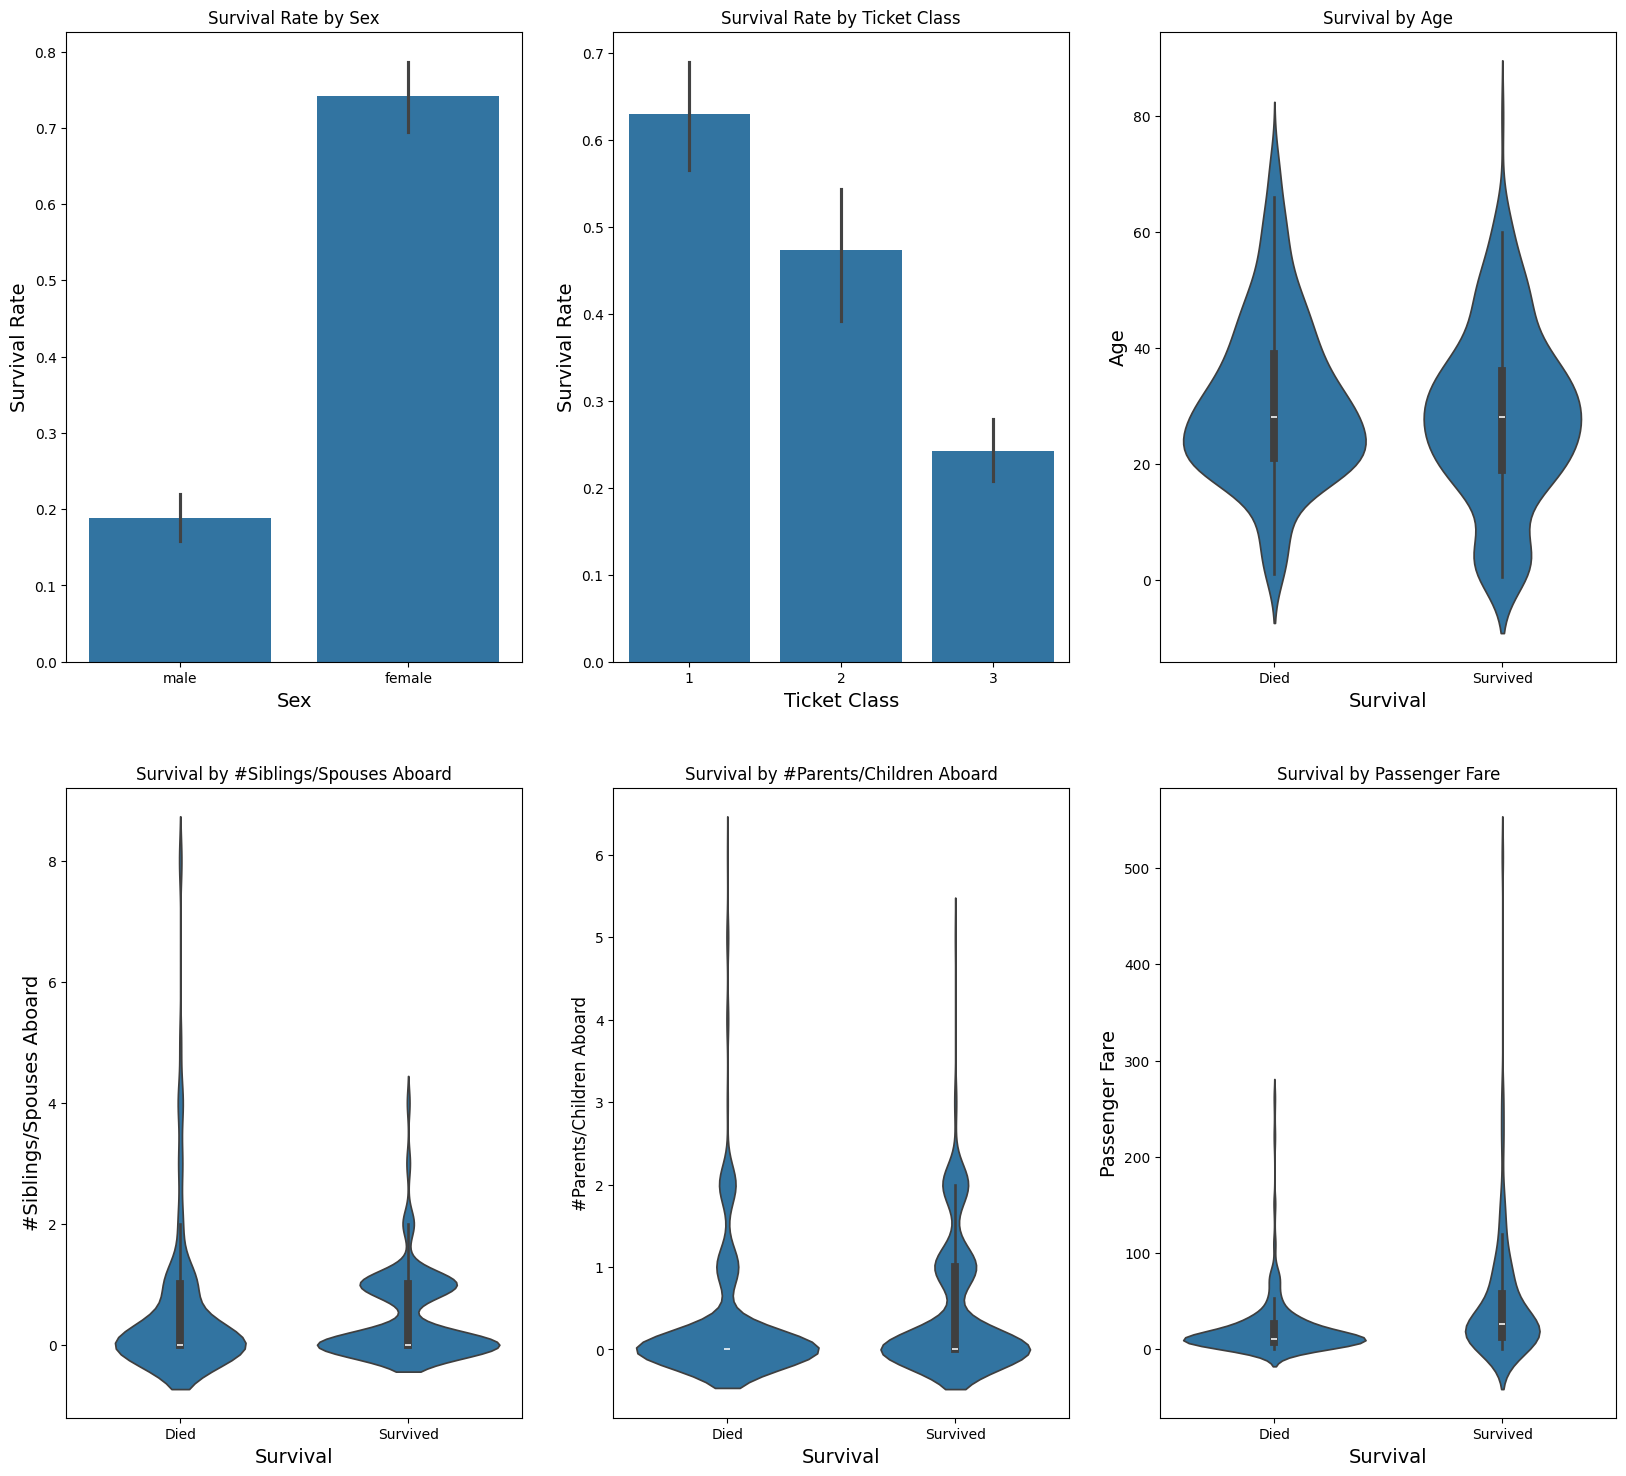

In [10]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 18))

# Sex
sns.barplot(data=train_set, x="Sex", y="Survived", ax = axes[0,0])
axes[0,0].set_title("Survival Rate by Sex", fontsize=12)
axes[0,0].set_xlabel("Sex", fontsize=14)
axes[0,0].set_ylabel("Survival Rate", fontsize=14)

# PClass
sns.barplot(data=train_set, x="Pclass", y="Survived", ax = axes[0,1])
axes[0,1].set_title("Survival Rate by Ticket Class", fontsize=12)
axes[0,1].set_xlabel("Ticket Class", fontsize=14)
axes[0,1].set_ylabel("Survival Rate", fontsize=14)

# Create text version of 'Survived' column for more interpretable plots
train_set["Survived_txt"] = train_set["Survived"].map({1: 'Survived', 0: 'Died'})

# Age
sns.violinplot(data=train_set, x="Survived_txt", y="Age", ax = axes[0,2])
axes[0,2].set_title("Survival by Age", fontsize=12)
axes[0,2].set_ylabel("Age", fontsize=14)
axes[0,2].set_xlabel("Survival", fontsize=14)

# SibSp
sns.violinplot(data=train_set, x="Survived_txt", y="SibSp", ax = axes[1,0])
axes[1,0].set_title("Survival by #Siblings/Spouses Aboard", fontsize=12)
axes[1,0].set_ylabel("#Siblings/Spouses Aboard", fontsize=14)
axes[1,0].set_xlabel("Survival", fontsize=14)

# Parch
sns.violinplot(data=train_set, x="Survived_txt", y="Parch", ax = axes[1,1])
axes[1,1].set_title("Survival by #Parents/Children Aboard", fontsize=12)
axes[1,1].set_ylabel("#Parents/Children Aboard", fontsize=12)
axes[1,1].set_xlabel("Survival", fontsize=14)

# Fare
sns.violinplot(data=train_set, x="Survived_txt", y="Fare", ax = axes[1,2])
axes[1,2].set_title("Survival by Passenger Fare", fontsize=12)
axes[1,2].set_ylabel("Passenger Fare", fontsize=14)
axes[1,2].set_xlabel("Survival", fontsize=14)

# Drop text survived column:
train_set.drop("Survived_txt", axis=1, inplace=True)

The plots above reveal several important patterns in the data. The first bar plot shows that female passengers were far more likely to survive than their male counterparts. Survival rates were also higher among first-class passengers compared to those in second and third class.

When comparing age distributions, children are disproportionately represented among the survivors, suggesting that youth may have been a significant factor in survival outcomes.

Interestingly, the distribution of siblings and spouses aboard varied noticeably between survivors and non-survivors. Survivors were less likely to have exactly one sibling or spouse on board and more likely to have either none or two or more.

Additionally, survivors tended to have paid higher fares on average than those who did not survive.

In contrast, the distribution of parents and children aboard was quite similar between the two groups, suggesting that this variable may offer limited predictive value for machine learning models.


There are three categorical variables we have yet to explore: Cabin, Embarked, and Name.



Cabin number is missing for 77.1% of passengers in the training set. From the [data description](https://www.kaggle.com/competitions/titanic/data), it is unclear whether null Cabin values are informative. Given that cabin information is missing a majority of the time, imputation of missing values would be inappropriate. Thus, Cabin will be excluded from all predictive models.

The Embarked variable represents the port of embarkation (Cherbourg, Queenstown, or Southampton) and is missing for only about 0.2% of passengers. Since this feature may hold predictive value, missing Embarked values will be imputed using the mode before training machine learning models. In the bar plot below, we see port of embarkation correlates with survival rate. Passengers who embarked at Cherbourg had a 55% chance of survival, while those who embarked at Southampton had a 34% chance of survival.

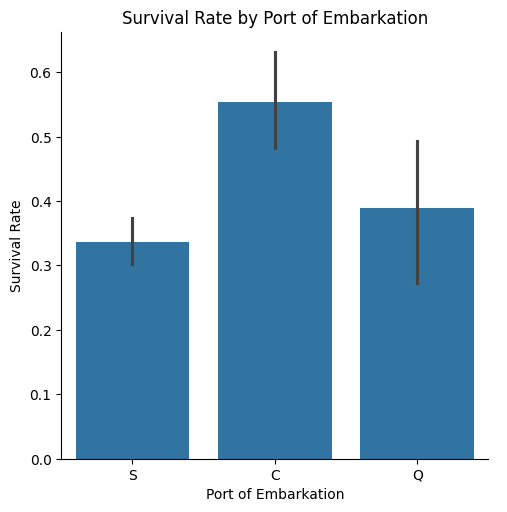

In [15]:
sns.catplot(data=train_set, x="Embarked", y="Survived", kind="bar")
plt.xlabel("Port of Embarkation")
plt.ylabel("Survival Rate")
plt.title("Survival Rate by Port of Embarkation")
plt.show()

The Name variable contains free-text entries that include first names, last names, maiden names, and titles or honorifics (e.g., “Mr.”, “Mrs.”, “Miss”). Each passenger has a unique name, so a machine learning model would interpret this as a categorical variable with 891 distinct levels, providing little predictive value. However, useful information can still be extracted. For example, many female passengers’ names contain the title “Mrs.”, which can be used to infer marital status, a feature that may correlate with survival rates.

In [11]:
train_set["Name_lower"] = train_set["Name"].str.lower()
train_set["married_woman"] = train_set["Name_lower"].str.contains("mrs")
train_set["married_woman"].value_counts()

,count
married_woman,
False,762
True,129


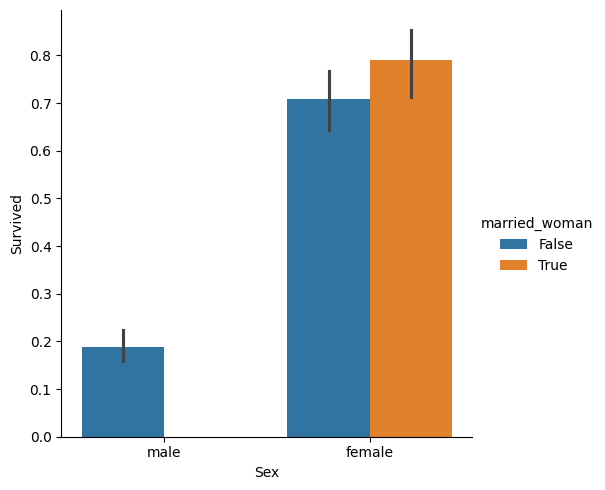

In [12]:
sns.catplot(data=train_set, x="Sex", y="Survived", hue="married_woman", kind="bar")

Married women had a slightly higher chance of survival compared to unmarried. We should try including married status of female passengers in the predictive model.

## 3. Build a data-cleaning and preprocessing pipeline

Build a pipeline that performs the following transformations:



*   Create a numerical Sex feature
*   Impute missing numeric features
*   (Optional) standardize numeric features

*   Impute missing port of embarkation
*   One-hot encode port of embarkation



In [32]:
# Note: I included BaseEstimator in this custom class so that I'll automatically get two extra methods (get_params() and set_params()) which will be useful for hyperparameter tuning
# I also included TransformerMixin to get the fit_transform() method

class titanic_data_prep(BaseEstimator, TransformerMixin):
  def __init__(self, sex_3levels = True, std_scale = True):
    """
    sex_3levels: if True (default), three indicator columns will be created indicating whether passenger is a married woman, an unmarried woman, or a man. If False, only one indicator variable will be created indicating whether passenger was male.
    std_scale: if True (default), numeric features will be standardized.
    """
    self.sex_3levels = sex_3levels
    self.std_scale = std_scale

  def fit(self, X, y=None):
    return self # nothing else to do

  def transform(self, X):
    # define index (needed for merging)
    X.index = X["PassengerId"]

    # create a numeric column for passenger sex
    X["Sex_num"] = X["Sex"].map({"female":0, "male": 1})

    # create a numeric married woman feature
    X["Name_lower"] = X["Name"].str.lower()
    X["Married_woman"] = X["Name_lower"].str.contains("mrs").map({True:1, False:0})
    X["Man"] = X["Sex_num"]
    X["Unmarried_woman"] = -1*(X["Married_woman"] + X["Man"]) + 1

    # Standardize numeric features
    if self.std_scale == True:
      scaler = StandardScaler()
      X_unscaled = X[["Pclass", "Age", "SibSp", "Parch", "Fare"]]
      X_scaled = pd.DataFrame(scaler.fit_transform(X_unscaled), columns = X_unscaled.columns, index = X_unscaled.index)

    else:
      X_scaled = X[["Pclass", "Age", "SibSp", "Parch", "Fare"]]

    # Define numeric and categorical columns
    if self.sex_3levels == True:
      X_num = pd.concat([X_scaled, X[["Married_woman", "Unmarried_woman", "Man"]]], axis=1, join="inner")
    else:
      X_num = pd.concat([X_scaled, X[["Sex_num"]]], axis=1, join="inner")

    X_cat = X[["Embarked"]]

    # Handle rows with missing values
    # Impute missing numeric features
    imputer = SimpleImputer(strategy="mean")
    imputer.fit(X_num)
    X_array = imputer.transform(X_num) # this is a plain NumPy array
    X_num = pd.DataFrame(X_array, columns = X_num.columns, index = X_num.index) # convert X_num back to a pandas dataframe

    # Impute missing port of embarkation
    imputer = SimpleImputer(strategy="most_frequent")
    imputer.fit(X_cat)
    X_array = imputer.transform(X_cat)
    X_cat = pd.DataFrame(X_array, columns = X_cat.columns, index = X_cat.index)


    # Perform one-hot encoding of categorical variable (Embarked)
    cat_encoder = OneHotEncoder()
    X_cat_1hot = cat_encoder.fit_transform(X_cat)
    X_cat_1hot = pd.DataFrame(X_cat_1hot.toarray(), columns = list(cat_encoder.categories_[0]), index=X_cat.index)


    # Combine X_cat_1hot and X_num into one Pandas dataframe
    X = pd.concat([X_num, X_cat_1hot], axis=1, join="inner")

    # Return cleaned dataframe
    return X

In [33]:
data_cleaner = titanic_data_prep()

In [34]:
X_train = data_cleaner.transform(train_set)
y_train = train_set["Survived"][train_set.index.isin(X_train.index)]

## 4. Train and tune machine learning models to predict survival

Use k-fold cross validation to test out five binary classification models. Compare model performance using the f1 metric.

In [40]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "SVC": SVC(),
    "KNN": KNeighborsClassifier()
}

In [41]:
results = {}

for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring="f1")
    results[name] = scores
    print(f"{name}: {scores.mean():.3f} (+/- {scores.std():.3f})")

Logistic Regression: 0.725 (+/- 0.024)
Random Forest: 0.740 (+/- 0.054)
Gradient Boosting: 0.759 (+/- 0.044)
SVC: 0.764 (+/- 0.034)
KNN: 0.733 (+/- 0.025)


C-Support Vector Classification achieved the best performance, with an average F1 score of 0.764.

Tune hyperparameters in the C-Support Vector Classification model. Start by creating a pipeline that first feeds data through custom pre-processing, then fits the model.

In [47]:
SVC_pipeline = Pipeline([
    ('data_cleaner', titanic_data_prep()),
    ('SVC', SVC()),
])

In [52]:
param_grid = {'data_cleaner__sex_3levels': [True, False], 'data_cleaner__std_scale': [True, False], 'SVC__C':[0.01, 0.1, 1, 10, 100], 'SVC__kernel': ['linear', 'rbf', 'poly'], 'SVC__class_weight': [None, 'balanced']}

In [53]:
grid_search = GridSearchCV(SVC_pipeline, param_grid, cv=5, scoring="f1")

In [54]:
test_gs = grid_search.fit(train_set, y_train)

In [63]:
print(f"Best Parameters: {test_gs.best_params_}\nBest F1 Score: {test_gs.best_score_}")


Best Parameters: {'SVC__C': 1, 'SVC__class_weight': None, 'SVC__kernel': 'poly', 'data_cleaner__sex_3levels': True, 'data_cleaner__std_scale': True}
Best F1 Score: 0.7611569029525685


The parameters and F1 of the best performing model are shown above.

Because there are not many features in the dataset to begin with, I will not be performing feature selection. However, feature selection (forward/backward) can be implemented within the Pipeline() above.

Define the final model:

In [66]:
final_model = test_gs.best_estimator_

## 5. Evaluate model performance on unseen test data

In [68]:
y_preds = final_model.predict(test_set)

In [69]:
# Save predictions for kaggle submission
pd.DataFrame({"PassengerId":test_set["PassengerId"], "Survived":y_preds.astype(int)}).to_csv("titanic_data/submission.csv", index=False)